# KE5105 - Building Electrical Consumption Forecasting

# Modelling 13 - Benchmark SVR model

## Summary of Findings
* **MRB** building dataset
* to be updated

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/Documents/KE5105/ETL',
 '/home/tkokkeng/python/python367/tsfvenv/lib',
 '/home/tkokkeng/Documents/KE5105/ETL/source',
 '/home/tkokkeng/Documents/KE5105/ETL/source/results',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu
import pickle
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# from keras.models import Sequential, load_model
# from keras import layers
# from keras.optimizers import RMSprop
# from keras.callbacks import ModelCheckpoint, TensorBoard
# from keras import backend

Using TensorFlow backend.


## Load data for building MRB

In [4]:
mrb_train = mu.load_data_by_bldg(['MRB'], 'imputed_train')

In [5]:
mrb_train[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31617 entries, 2015-06-12 07:30:00 to 2017-03-31 23:30:00
Data columns (total 10 columns):
PWMMRIC1                     29851 non-null float64
PWMMRIC2                     29851 non-null float64
BTUMochtarRiady              29448 non-null float64
PWMMRIC1_30min_avg           29818 non-null float64
PWMMRIC2_30min_avg           29818 non-null float64
BTUMochtarRiady_30min_avg    29416 non-null float64
PWM_sumadd                   29818 non-null float64
PWM_30min_avg                29861 non-null float64
BTU_sumadd                   29416 non-null float64
BTU_30min_avg                29469 non-null float64
dtypes: float64(10)
memory usage: 2.7 MB


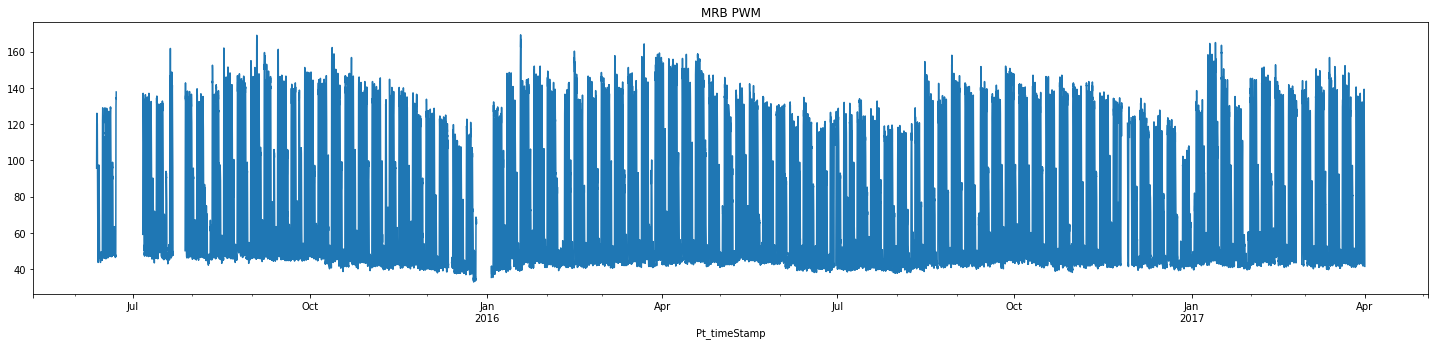

In [6]:
mrb_train_df = mrb_train[0][1]
mrb_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='MRB PWM')

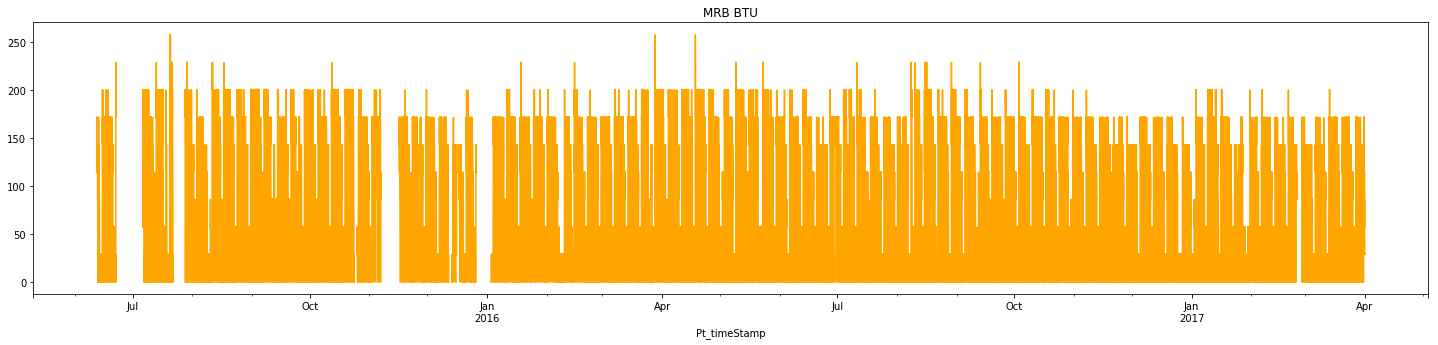

In [7]:
mrb_train_df['BTU_30min_avg'].plot(figsize=(25, 5), title='MRB BTU', color='orange')

## Split a validation set out from the train set

In [8]:
mrb_train_split_df = mrb_train_df[:20000]
mrb_val_split_df = mrb_train_df[20000:]

In [9]:
print('train split = %s\nvalidation split = %s' % (mrb_train_split_df.shape, mrb_val_split_df.shape))

train split = (20000, 10)
validation split = (11617, 10)


## Transform the training data

* Normalise the data - convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [10]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [11]:
mrb_train_data = my_pipeline.fit_transform(mrb_train_split_df)
mrb_train_data

array([[0.46055046, 0.66601942],
       [0.55412844, 0.66699029],
       [0.60366972, 0.66601942],
       ...,
       [0.16880734, 0.11067961],
       [0.07889908, 0.11067961],
       [0.07155963, 0.        ]])

In [12]:
mrb_train_data.shape

(20000, 2)

Text(0.5, 1.0, 'Normalised PWM Training Data')

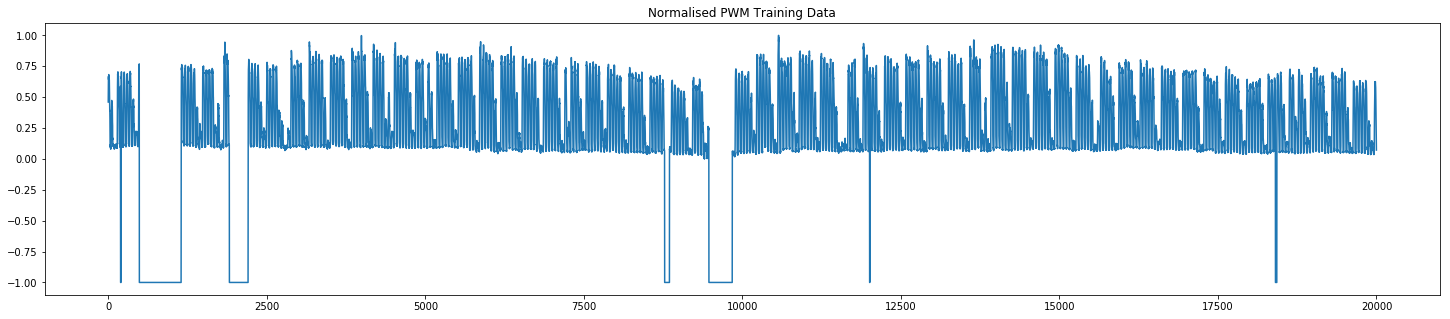

In [13]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

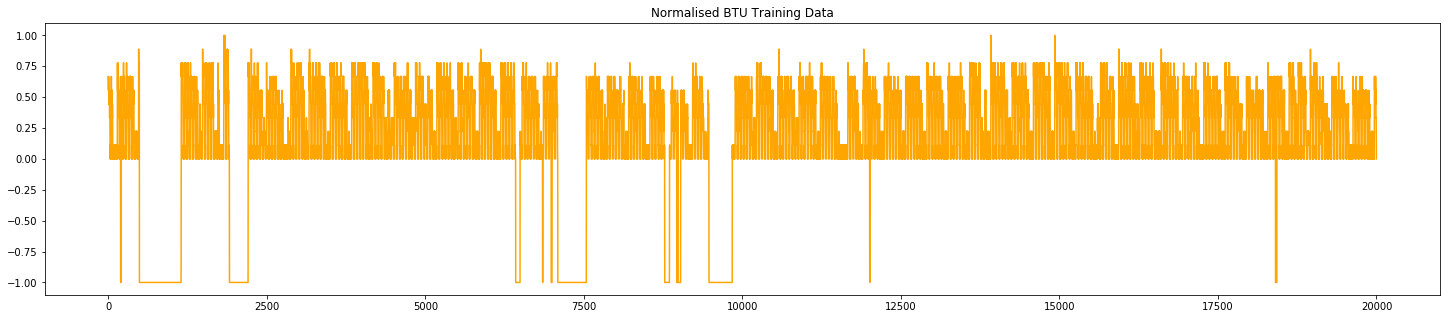

In [14]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

In [15]:
mrb_val_data = my_pipeline.transform(mrb_val_split_df)
mrb_val_data

array([[0.05321101, 0.        ],
       [0.07155963, 0.11067961],
       [0.05688073, 0.        ],
       ...,
       [0.13211009, 0.11067961],
       [0.10825688, 0.11426533],
       [0.06314127, 0.11424788]])

In [16]:
mrb_val_data.shape

(11617, 2)

Text(0.5, 1.0, 'Normalised PWM Validation Data')

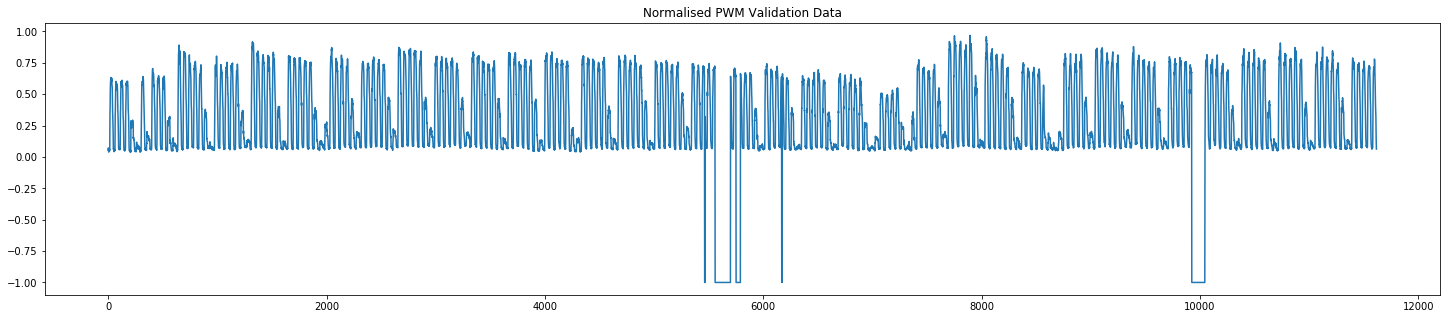

In [17]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_val_data.shape[0]), mrb_val_data[:, 0])
plt.title('Normalised PWM Validation Data')

Text(0.5, 1.0, 'Normalised BTU Validation Data')

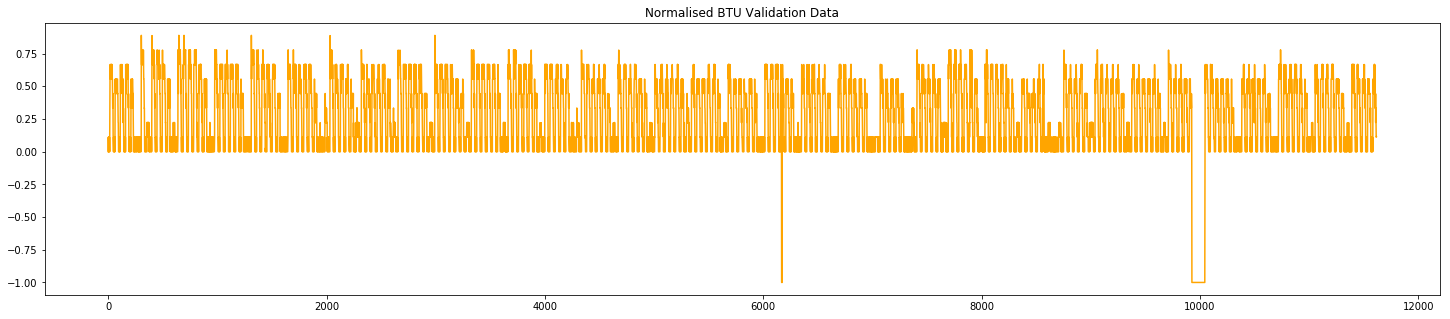

In [18]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_val_data.shape[0]), mrb_val_data[:, 1], color='orange')
plt.title('Normalised BTU Validation Data')

## Create the numpy arrays for X and y

In [19]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

In [20]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [21]:
X_list, y_list = [], []
for i in range(gen_train.__len__()):
    samples, targets = gen_train.__getitem__(i)
    X_list.append(samples)
    y_list.append(targets)
X_train = np.concatenate(X_list)
y_train = np.concatenate(y_list)

In [22]:
X_train = X_train.reshape((-1, lookback * 2))
X_train.shape

(18326, 480)

In [23]:
X_train == -1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [24]:
# mask = np.apply_along_axis(any, axis=1, arr=(X_train == mu.MASK_VALUE))
mask = np.apply_along_axis(all, axis=1, arr=(X_train > mu.MASK_VALUE))

In [25]:
np.sum(mask)

15271

In [26]:
X_train = X_train[mask,]
y_train = y_train[mask,]
print(X_train.shape, y_train.shape)

(15271, 480) (15271,)


In [27]:
X_list, y_list = [], []
for i in range(gen_val.__len__()):
    samples, targets = gen_val.__getitem__(i)
    X_list.append(samples)
    y_list.append(targets)
X_val = np.concatenate(X_list)
y_val = np.concatenate(y_list)
X_val = X_val.reshape((-1, lookback * 2))
mask = np.apply_along_axis(any, axis=1, arr=(X_val == mu.MASK_VALUE))
X_val = X_val[np.logical_not(mask),]
y_val = y_val[np.logical_not(mask),]
print(X_val.shape, y_val.shape)

(10201, 480) (10201,)


In [28]:
# Custom mape metric. Skips all zero values of y-true in computing the mape metric.
# import tensorflow as tf
# def mape_skip_zeros(y_true, y_pred):
#     y_true1 = tf.boolean_mask(y_true, y_true > 0)
#     y_pred1 = tf.boolean_mask(y_pred, y_true > 0)
#     diff = backend.abs((y_true1 - y_pred1) / y_true1)
#     return 100. * backend.mean(diff, axis=-1)

## SVR Model 1

In [41]:
model = svm.SVR(kernel='rbf', gamma='auto', C=1, cache_size=1000, max_iter=-1)

In [42]:
model.fit(X_train, y_train)

SVR(C=1, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [43]:
mrb_train_preds = model.predict(X_train)
mrb_val_preds = model.predict(X_val)

In [44]:
mae_train, mae_val = mean_absolute_error(mrb_train_preds, y_train), mean_absolute_error(mrb_val_preds, y_val)
print('Training Loss = {:.4f}\nValidation Loss = {:.4f}\nTraining MAE = {:.4f}\nValidation MAE = {:.4f}'.format(
    mae_train, mae_val,
    mae_train * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()),
    mae_val * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())))

Training Loss = 0.0369
Validation Loss = 0.0381
Training MAE = 5.0211
Validation MAE = 5.1944


In [45]:
print(mrb_train_preds.shape, mrb_val_preds.shape)

(15271,) (10201,)


In [46]:
mrb_train_preds = mrb_train_preds.reshape((-1, 1))
mrb_train_preds1 = np.concatenate([mrb_train_preds, np.zeros((mrb_train_preds.shape[0], 1))], axis=1)
mrb_train_preds1.shape

(15271, 2)

In [46]:
mrb_train_preds1 = my_pipeline.inverse_transform(mrb_train_preds1)
mrb_train_preds1

array([[64.38875239,  0.        ],
       [63.65375365,  0.        ],
       [62.14262953,  0.        ],
       ...,
       [58.50468701,  0.        ],
       [51.31839329,  0.        ],
       [46.34245632,  0.        ]])

In [48]:
mrb_train_data.shape

(20000, 2)

In [49]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if (mrb_train_data[i, 0] > mu.MASK_VALUE) and (np.all(mrb_train_data[i - lookback:i, 0] > mu.MASK_VALUE)) and (np.all(mrb_train_data[i - lookback:i, 1] > mu.MASK_VALUE)):
        mrb_train_preds_withnan[i] = mrb_train_preds1[j, 0]
        j += 1
mrb_train_preds_withnan.shape

(20000, 1)

In [50]:
mrb_val_preds = mrb_val_preds.reshape((-1, 1))
mrb_val_preds1 = np.concatenate([mrb_val_preds, np.zeros((mrb_val_preds.shape[0], 1))], axis=1)
mrb_val_preds1 = my_pipeline.inverse_transform(mrb_val_preds1)
mrb_val_preds_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    if (mrb_val_data[i, 0] > mu.MASK_VALUE) and (np.all(mrb_val_data[i - lookback:i, 0] > mu.MASK_VALUE)) and (np.all(mrb_val_data[i - lookback:i, 1] > mu.MASK_VALUE)):
        mrb_val_preds_withnan[i] = mrb_val_preds1[j, 0]
        j += 1
mrb_val_preds_withnan.shape

(11617, 1)

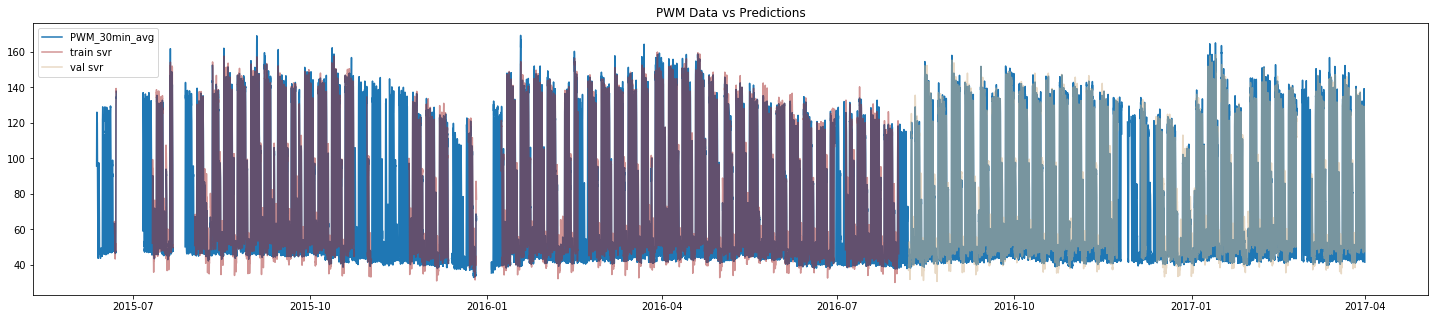

In [51]:
plt.figure(figsize=(25, 5))
plt.plot(mrb_train_df['PWM_30min_avg'])
plt.plot(mrb_train_df.index[:20000], mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train svr')
plt.plot(mrb_train_df.index[20000:], mrb_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val svr')
plt.title('PWM Data vs Predictions')
plt.legend()

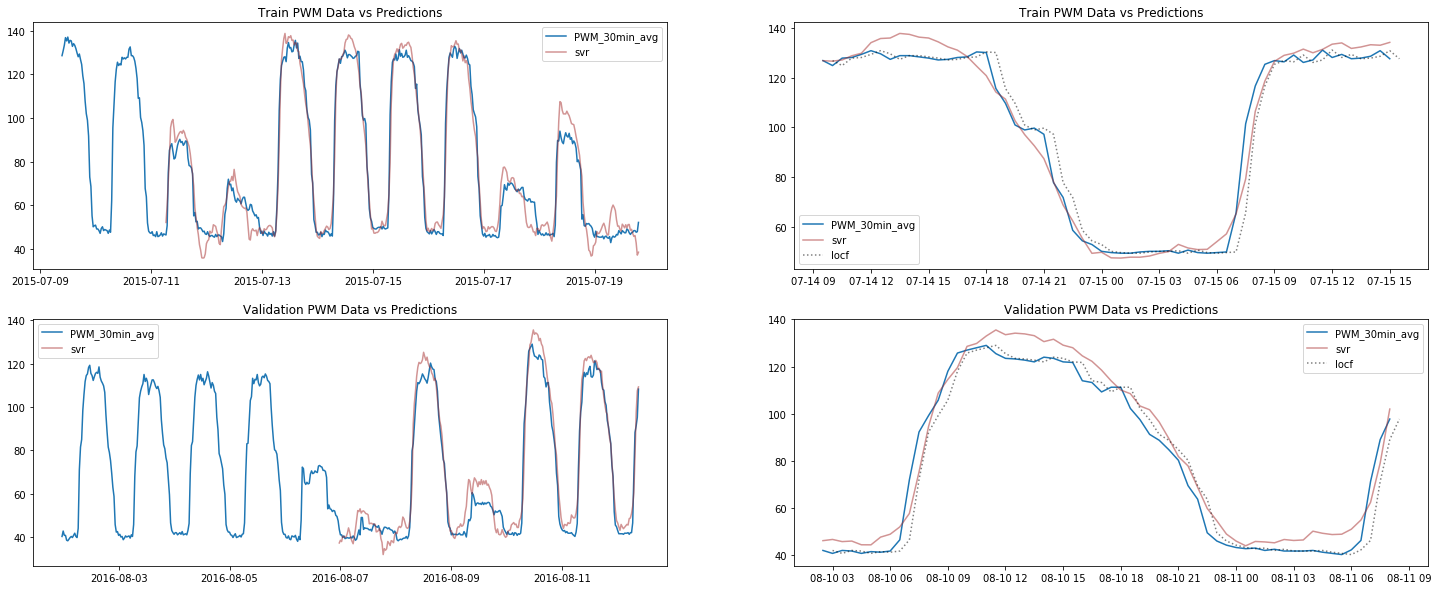

In [52]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
# plt.plot(mrb_train_df.iloc[1000:1500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
# plt.plot(mrb_train_df.index[1000:1500], mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.iloc[1300:1800, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1300:1800], mrb_train_preds_withnan[1300:1800, :].flatten(), color='brown', alpha=.5, label='svr')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
# plt.plot(mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
# plt.plot(mrb_train_df.index[1240:1300], mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
# plt.plot(mrb_train_df.index[1241:1301], mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.plot(mrb_train_df.iloc[1540:1600, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1540:1600], mrb_train_preds_withnan[1540:1600].flatten(), color='brown', alpha=.5, label='svr')
plt.plot(mrb_train_df.index[1541:1601], mrb_train_df.iloc[1540:1600, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(mrb_train_df.iloc[20000:20500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20000:20500], mrb_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='svr')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='svr')
plt.plot(mrb_train_df.index[20391:20451], mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()

## SVR Model 2

In [53]:
model = svm.SVR(kernel='rbf', gamma='auto', C=1000, cache_size=1000, max_iter=-1)
model.fit(X_train, y_train)
mrb_train_preds = model.predict(X_train)
mrb_val_preds = model.predict(X_val)
mae_train, mae_val = mean_absolute_error(mrb_train_preds, y_train), mean_absolute_error(mrb_val_preds, y_val)
print('Training Loss = {:.4f}\nValidation Loss = {:.4f}\nTraining MAE = {:.4f}\nValidation MAE = {:.4f}'.format(
    mae_train, mae_val,
    mae_train * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()),
    mae_val * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())))

Training Loss = 0.0314
Validation Loss = 0.0313
Training MAE = 4.2730
Validation MAE = 4.2608


In [54]:
mrb_train_preds = mrb_train_preds.reshape((-1, 1))
mrb_train_preds1 = np.concatenate([mrb_train_preds, np.zeros((mrb_train_preds.shape[0], 1))], axis=1)
mrb_train_preds1 = my_pipeline.inverse_transform(mrb_train_preds1)
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if (mrb_train_data[i, 0] > mu.MASK_VALUE) and (np.all(mrb_train_data[i - lookback:i, 0] > mu.MASK_VALUE)) and (np.all(mrb_train_data[i - lookback:i, 1] > mu.MASK_VALUE)):
        mrb_train_preds_withnan[i] = mrb_train_preds1[j, 0]
        j += 1
mrb_val_preds = mrb_val_preds.reshape((-1, 1))
mrb_val_preds1 = np.concatenate([mrb_val_preds, np.zeros((mrb_val_preds.shape[0], 1))], axis=1)
mrb_val_preds1 = my_pipeline.inverse_transform(mrb_val_preds1)
mrb_val_preds_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    if (mrb_val_data[i, 0] > mu.MASK_VALUE) and (np.all(mrb_val_data[i - lookback:i, 0] > mu.MASK_VALUE)) and (np.all(mrb_val_data[i - lookback:i, 1] > mu.MASK_VALUE)):
        mrb_val_preds_withnan[i] = mrb_val_preds1[j, 0]
        j += 1

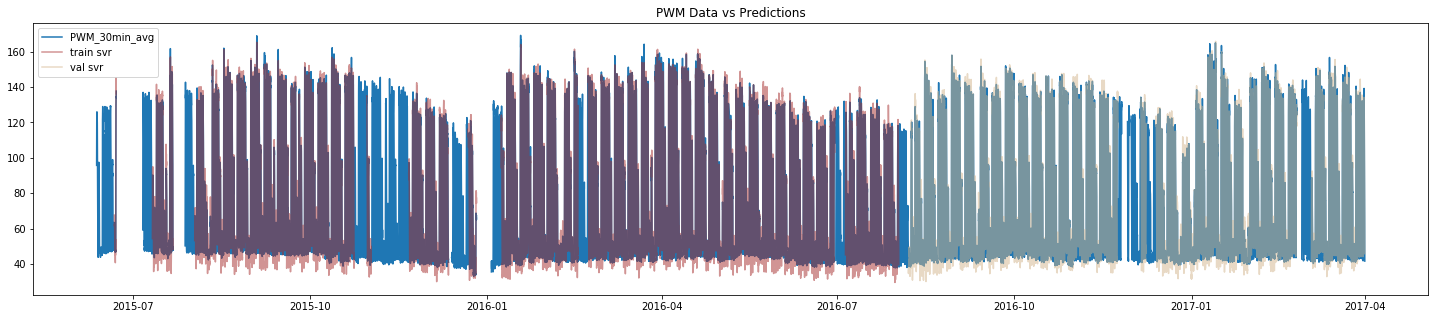

In [55]:
plt.figure(figsize=(25, 5))
plt.plot(mrb_train_df['PWM_30min_avg'])
plt.plot(mrb_train_df.index[:20000], mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train svr')
plt.plot(mrb_train_df.index[20000:], mrb_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val svr')
plt.title('PWM Data vs Predictions')
plt.legend()

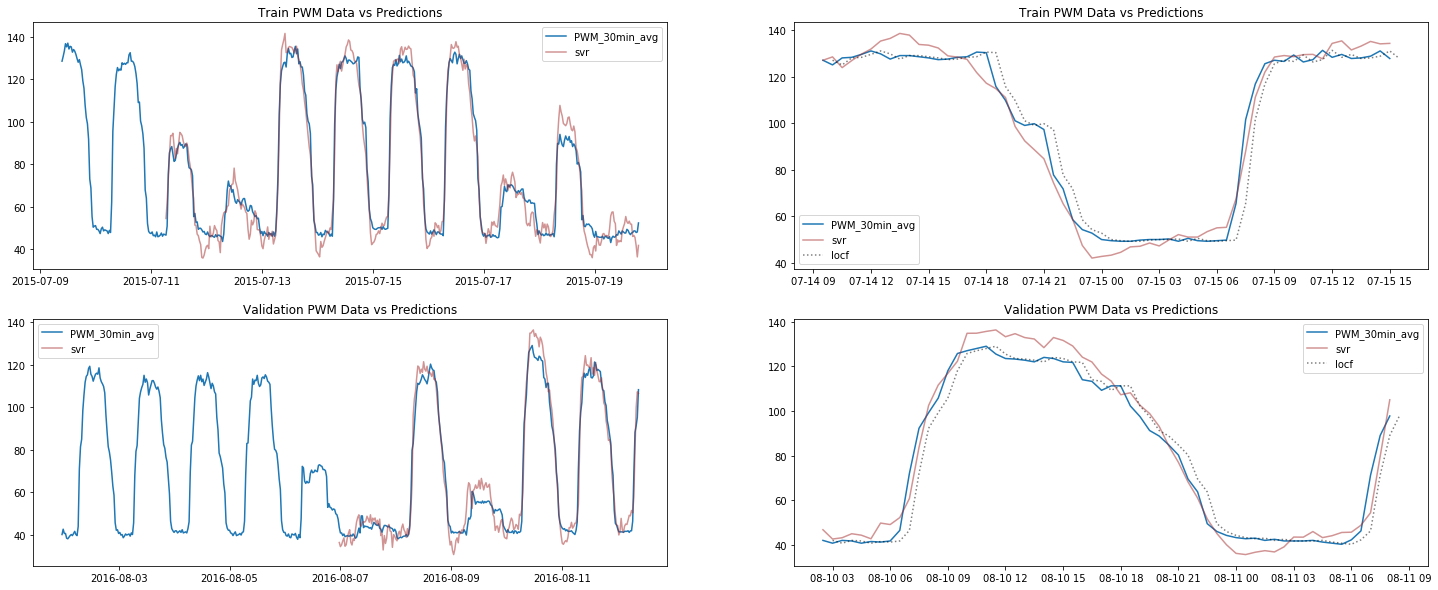

In [56]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
# plt.plot(mrb_train_df.iloc[1000:1500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
# plt.plot(mrb_train_df.index[1000:1500], mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.iloc[1300:1800, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1300:1800], mrb_train_preds_withnan[1300:1800, :].flatten(), color='brown', alpha=.5, label='svr')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
# plt.plot(mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
# plt.plot(mrb_train_df.index[1240:1300], mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
# plt.plot(mrb_train_df.index[1241:1301], mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.plot(mrb_train_df.iloc[1540:1600, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1540:1600], mrb_train_preds_withnan[1540:1600].flatten(), color='brown', alpha=.5, label='svr')
plt.plot(mrb_train_df.index[1541:1601], mrb_train_df.iloc[1540:1600, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(mrb_train_df.iloc[20000:20500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20000:20500], mrb_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='svr')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='svr')
plt.plot(mrb_train_df.index[20391:20451], mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()

## Grid Search for Gamma and C Parameters

In [64]:
# First run
# param_grid = {'gamma': [.1, 1, 10], 'C': [.01, 1, 100]}

# Second run
param_grid = {'gamma': [1e-4, .001, 0.01], 'C': [.01, 1, 100]}

In [65]:
tscv = TimeSeriesSplit(n_splits=5)

In [66]:
model = svm.SVR(kernel='rbf', cache_size=1000, max_iter=-1)

In [67]:
mrb_data = my_pipeline.fit_transform(mrb_train_df)
gen_cv = mu.DataGenerator(mrb_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_data) - 1,
                             batch_size=batch_size, step=step)
X_list, y_list = [], []
for i in range(gen_cv.__len__()):
    samples, targets = gen_cv.__getitem__(i)
    X_list.append(samples)
    y_list.append(targets)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
X = X.reshape((-1, lookback * 2))
mask = np.apply_along_axis(any, axis=1, arr=(X == mu.MASK_VALUE))
X = X[np.logical_not(mask),]
y = y[np.logical_not(mask),]
print(X.shape, y.shape)

(25712, 480) (25712,)


In [68]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=tscv)

In [69]:
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
grid_result = grid.fit(X, y)
print('\nGrid Search Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-03-13 14:15:43.145749



Grid Search Duration = 0:40:22.510587


In [72]:
cv_results = pd.DataFrame.from_dict(grid_result.cv_results_, orient='columns')
cv_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 22 columns):
mean_fit_time         9 non-null float64
std_fit_time          9 non-null float64
mean_score_time       9 non-null float64
std_score_time        9 non-null float64
param_C               9 non-null object
param_gamma           9 non-null object
params                9 non-null object
split0_test_score     9 non-null float64
split1_test_score     9 non-null float64
split2_test_score     9 non-null float64
split3_test_score     9 non-null float64
split4_test_score     9 non-null float64
mean_test_score       9 non-null float64
std_test_score        9 non-null float64
rank_test_score       9 non-null int32
split0_train_score    9 non-null float64
split1_train_score    9 non-null float64
split2_train_score    9 non-null float64
split3_train_score    9 non-null float64
split4_train_score    9 non-null float64
mean_train_score      9 non-null float64
std_train_score       9 non-null float64
dt

/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_a

In [80]:
# cv_results.to_csv('svr-gridsearchcv-results1.csv', index=False)
cv_results.to_csv('svr-gridsearchcv-results2.csv', index=False)

In [30]:
cv_results1 = pd.read_csv(os.path.join('final results', 'SVR', 'svr-gridsearchcv-results1.csv'))
cv_results2 = pd.read_csv(os.path.join('final results', 'SVR', 'svr-gridsearchcv-results2.csv'))
all_results = pd.concat([cv_results1, cv_results2])

In [34]:
all_results.loc[:, ['param_C', 'param_gamma', 'mean_test_score']].sort_values('mean_test_score', ascending=False).reset_index(drop=True)

,param_C,param_gamma,mean_test_score
0,100.00,0.0010,-0.033654
1,100.00,0.0100,-0.034571
2,1.00,0.0100,-0.035277
3,100.00,0.0001,-0.037868
4,1.00,0.0010,-0.045082
5,1.00,0.1000,-0.053439
6,100.00,0.1000,-0.053439
7,0.01,0.0100,-0.063863
8,1.00,0.0001,-0.067059
9,0.01,0.1000,-0.070086


## Best SVR Model

In [35]:
best_model = svm.SVR(kernel='rbf', gamma=0.001, C=100, cache_size=1000, max_iter=-1)
best_model.fit(X_train, y_train)
mrb_train_preds = best_model.predict(X_train)
mrb_val_preds = best_model.predict(X_val)
mae_train, mae_val = mean_absolute_error(mrb_train_preds, y_train), mean_absolute_error(mrb_val_preds, y_val)
print('Training Loss = {:.4f}\nValidation Loss = {:.4f}\nTraining MAE = {:.4f}\nValidation MAE = {:.4f}'.format(
    mae_train, mae_val,
    mae_train * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()),
    mae_val * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())))

Training Loss = 0.0318
Validation Loss = 0.0318
Training MAE = 4.3373
Validation MAE = 4.3375


In [36]:
mrb_train_preds = mrb_train_preds.reshape((-1, 1))
mrb_train_preds1 = np.concatenate([mrb_train_preds, np.zeros((mrb_train_preds.shape[0], 1))], axis=1)
mrb_train_preds1 = my_pipeline.inverse_transform(mrb_train_preds1)
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if (mrb_train_data[i, 0] > mu.MASK_VALUE) and (np.all(mrb_train_data[i - lookback:i, 0] > mu.MASK_VALUE)) and (np.all(mrb_train_data[i - lookback:i, 1] > mu.MASK_VALUE)):
        mrb_train_preds_withnan[i] = mrb_train_preds1[j, 0]
        j += 1
mrb_val_preds = mrb_val_preds.reshape((-1, 1))
mrb_val_preds1 = np.concatenate([mrb_val_preds, np.zeros((mrb_val_preds.shape[0], 1))], axis=1)
mrb_val_preds1 = my_pipeline.inverse_transform(mrb_val_preds1)
mrb_val_preds_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    if (mrb_val_data[i, 0] > mu.MASK_VALUE) and (np.all(mrb_val_data[i - lookback:i, 0] > mu.MASK_VALUE)) and (np.all(mrb_val_data[i - lookback:i, 1] > mu.MASK_VALUE)):
        mrb_val_preds_withnan[i] = mrb_val_preds1[j, 0]
        j += 1

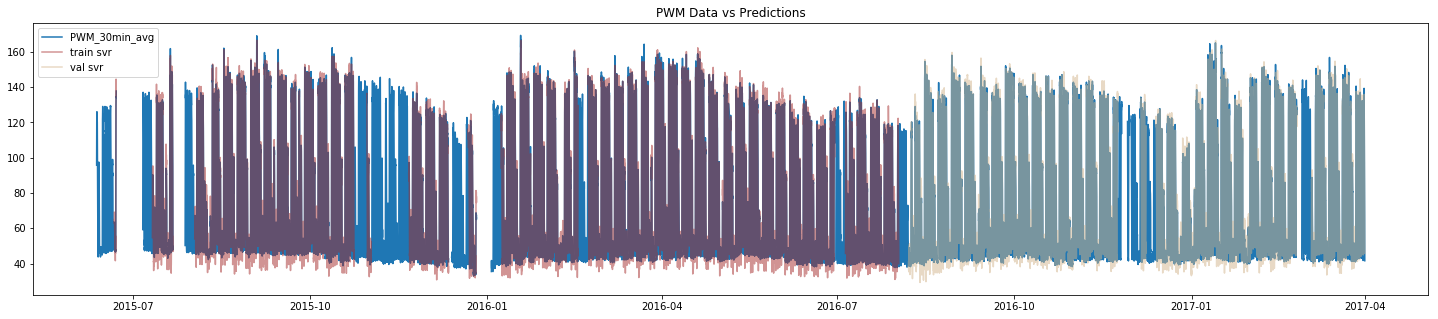

In [40]:
plt.figure(figsize=(25, 5))
plt.plot(mrb_train_df['PWM_30min_avg'])
plt.plot(mrb_train_df.index[:20000], mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train svr')
plt.plot(mrb_train_df.index[20000:], mrb_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val svr')
plt.title('PWM Data vs Predictions')
plt.legend()

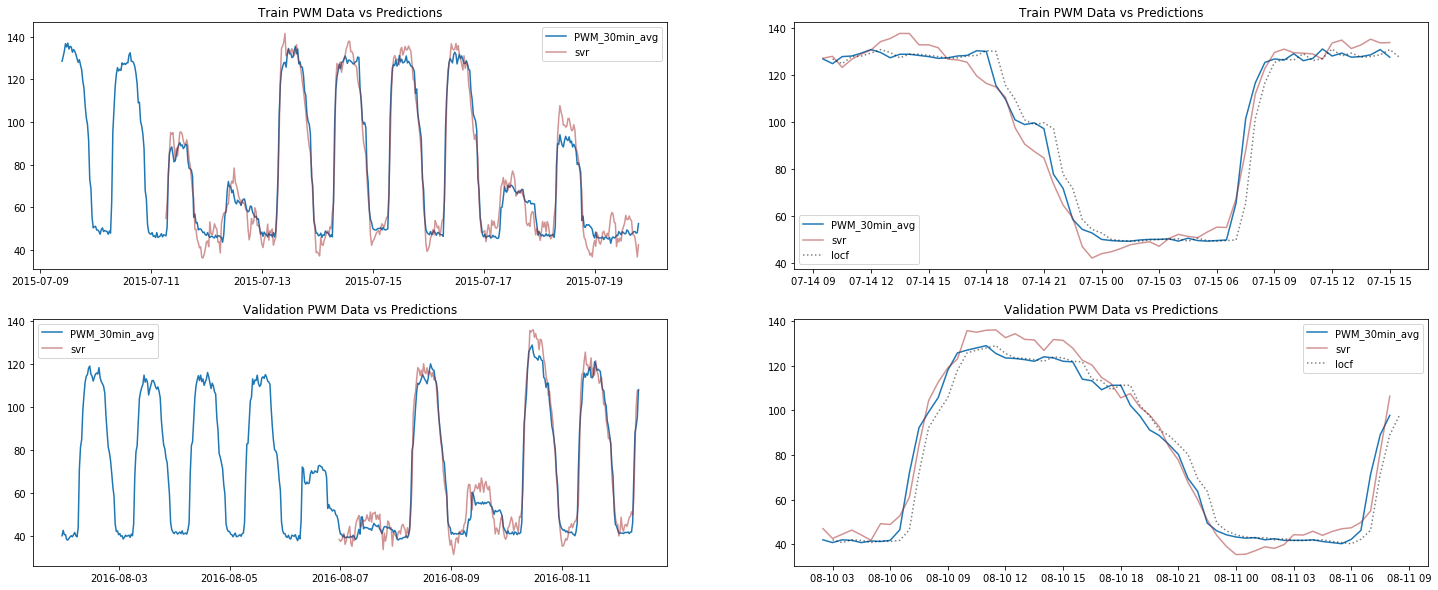

In [39]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
# plt.plot(mrb_train_df.iloc[1000:1500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
# plt.plot(mrb_train_df.index[1000:1500], mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.iloc[1300:1800, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1300:1800], mrb_train_preds_withnan[1300:1800, :].flatten(), color='brown', alpha=.5, label='svr')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
# plt.plot(mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
# plt.plot(mrb_train_df.index[1240:1300], mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
# plt.plot(mrb_train_df.index[1241:1301], mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.plot(mrb_train_df.iloc[1540:1600, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1540:1600], mrb_train_preds_withnan[1540:1600].flatten(), color='brown', alpha=.5, label='svr')
plt.plot(mrb_train_df.index[1541:1601], mrb_train_df.iloc[1540:1600, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(mrb_train_df.iloc[20000:20500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20000:20500], mrb_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='svr')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='svr')
plt.plot(mrb_train_df.index[20391:20451], mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()